In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
!pip install xlrd

ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'c:\\python39\\Scripts\\runxlrd.py'
Consider using the `--user` option or check the permissions.




  Using cached xlrd-2.0.1-py2.py3-none-any.whl (96 kB)


You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


We are going to do time series analysis and forecasting for furniture sales.

In [4]:
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

We have a good 4-year furniture sales data. 

In [5]:
furniture['Order Date'].min()

Timestamp('2014-01-06 00:00:00')

In [6]:
furniture['Order Date'].max()

Timestamp('2017-12-30 00:00:00')

## Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [7]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

In [8]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [9]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [10]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


## Indexing with time series data

In [11]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [12]:
y = furniture['Sales'].resample('MS').mean()

Have a quick peek 2017 sales data.

In [20]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

## Visualizing furniture sales time series data

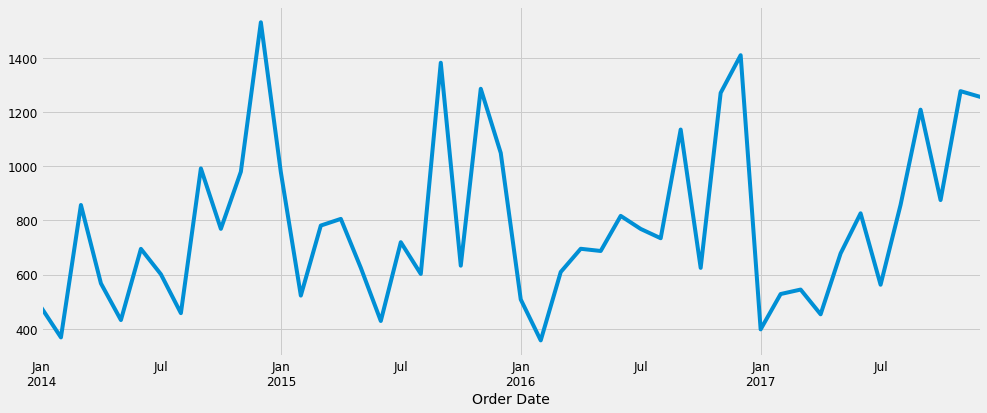

In [21]:
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always a strong upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

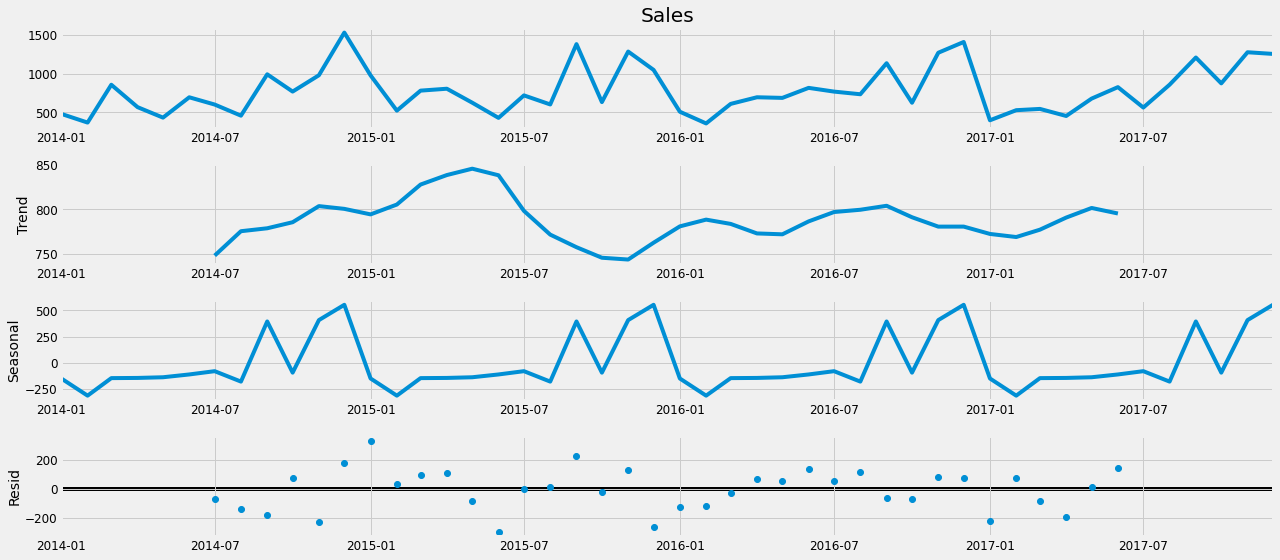

In [42]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

## Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

Parameter Selection for the ARIMA Time Series Model

In [23]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [24]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1647.4988952660767
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.71701309202774
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.2702899793669
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418337


C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1180.9590407725361
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.248828030213
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758096


C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2647.183266514711
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809162
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.62613896733006
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.54421685134963
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2505.8888386344033


C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946866
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576435603
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944


C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1300.1169411531337
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.6378567198382
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:304.96712281679663
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1069.0949802357025
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:306.9113200151421
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817027


C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1900.0164447746367
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.8705548482537
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:279.58062333599605
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.18329774427525
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2430.301806680695
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.75743684172403
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.55766214612396
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067712
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1320.8312942711116
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.46321478521355
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:304.20776751609714


C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.9259367935197
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1237.080019658141


C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.4664675084599
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:304.58426921438075
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.7794442186699


C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2633.4160715504295
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.3685195815127
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:293.3422193965861
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323876707


C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2492.6136645504607
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.01560023791114
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:293.751318817343
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1351.3762872032455
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.2003422281134


C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:300.2130611619096
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.3403658786717
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1534.346498319395
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.6270901345384
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:302.32649925040613
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019835393


C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1292.6653689794325
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.4762687610095
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:281.38730069394046
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.5250354660796
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2317.662920455282
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.7875439529213
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:283.3661014416119


In [25]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


In [5]:
!pip install statsmodel

ERROR: Could not find a version that satisfies the requirement statsmodel (from versions: none)
ERROR: No matching distribution found for statsmodel
You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


In [8]:
import statsmodels as sm



In [9]:
sm.__version__

'0.13.2'

In [10]:
!pip install mkl-service

     -------------------------------------- 50.7/50.7 KB 879.3 kB/s eta 0:00:00
     -------------------------------------- 229.8/229.8 MB 5.6 MB/s eta 0:00:00
     ------------------------------------- 278.1/278.1 KB 17.9 MB/s eta 0:00:00
     ---------------------------------------- 4.1/4.1 MB 8.9 MB/s eta 0:00:00


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\python39\\Library'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


In [26]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1152x576 with 0 Axes>

## Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017-07-01 to the end of the data.

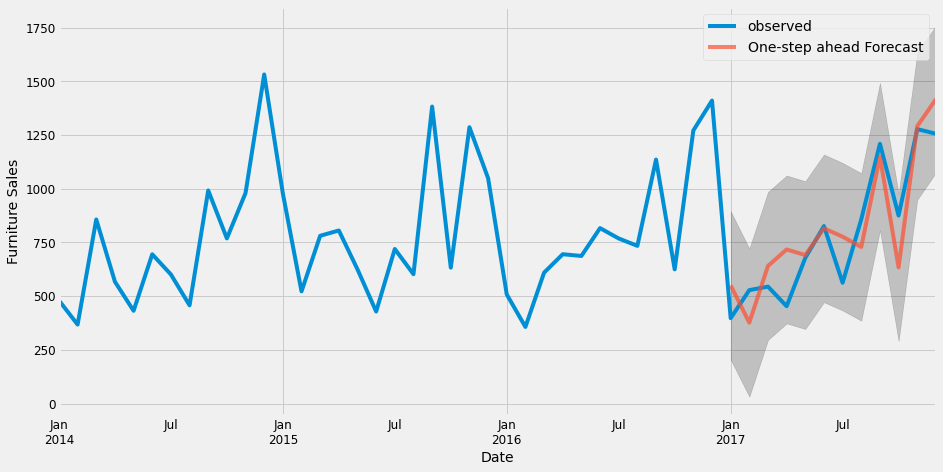

In [27]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year.

In [28]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22993.56


In [29]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

## Producing and visualizing forecasts

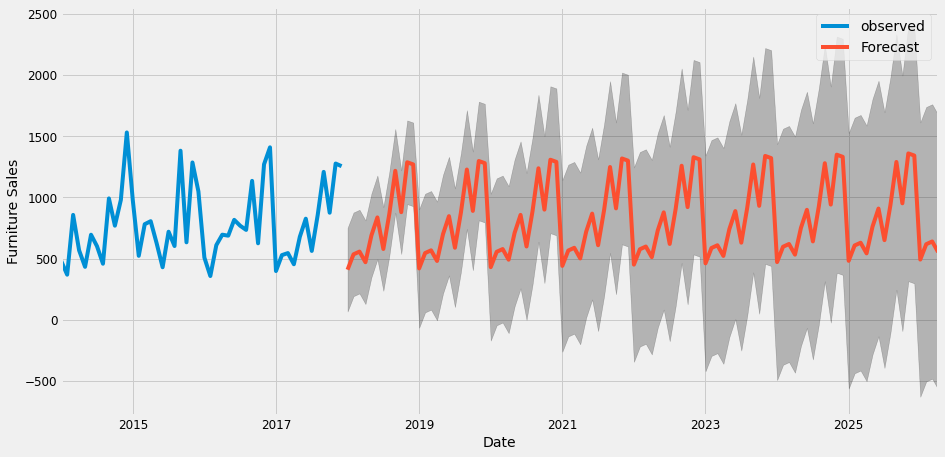

In [30]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

The above time series analysis for furniture makes me curious about other categories, and how do they compare with each other onver time. Therefore, we are going to compare time series of furniture and office supplier.

## Time Series comparison furniture sales and Office Supplies

### Data Preprocessing

In [31]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']

According to our data, there were way more number of sales from Office Supplies than from Furniture over the years.

In [32]:
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [33]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

Have a quick peek, perfect!

In [34]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


In [35]:
office.head()

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,685.340
4,2014-01-07,10.430


### Data exploration

We are going to compare two categories' sales in the same time period. This means combine two data frames into one and plot these two categories' time series into one plot.

In [36]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


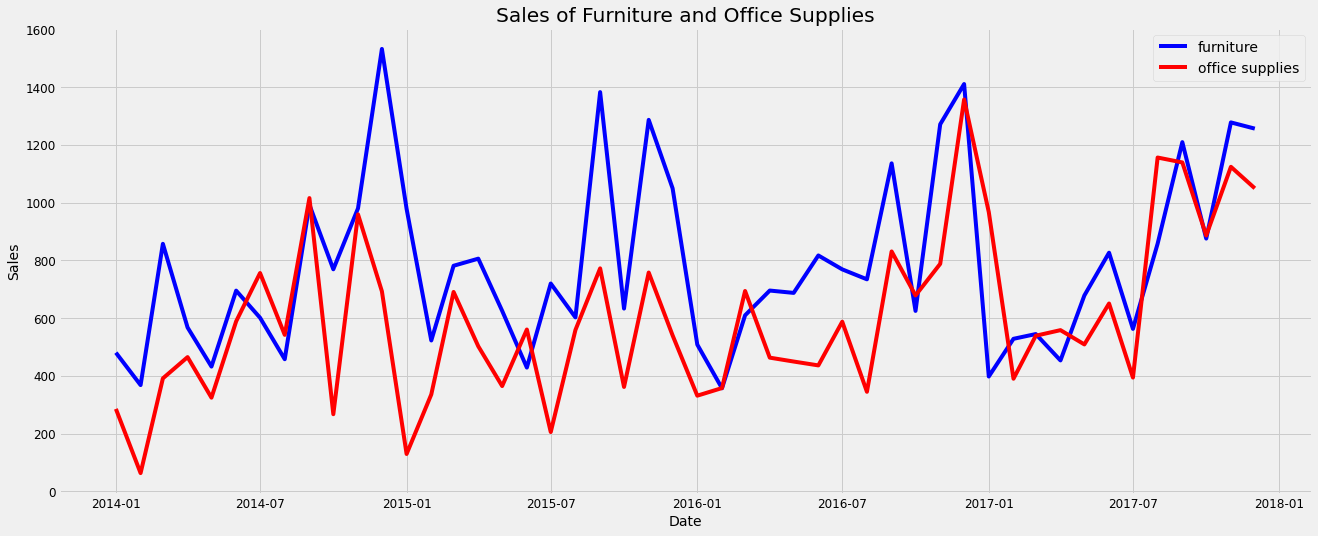

In [37]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

We observe that sales of furniture and office supplies shared a similar seasonal pattern. Early of the year is the off season for both of the two categories. It seems summer time is quiet for office supplies too. in addition, average daily sales for furniture are higher than those of office supplies in most of the months. It is understandable, as the value of furniture should be much higher than those of office supplies. Occationaly, office supplies passed furnitue on average daily sales. Let's find out when was the first time office supplies' sales surpassed those of furniture's. 

In [38]:
first_date = store.ix[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']

print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

AttributeError: 'DataFrame' object has no attribute 'ix'

It was July 2014.

### Time Series Modeling with Prophet

Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

In [40]:
!pip install fbprophet

  error: subprocess-exited-with-error
  


     ---------------------------------------- 64.0/64.0 KB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 985.1/985.1 KB 4.8 MB/s eta 0:00:00
     ---------------------------------------- 47.9/47.9 KB 2.4 MB/s eta 0:00:00
     ------------------------------------- 172.1/172.1 KB 10.1 MB/s eta 0:00:00
     ---------------------------------------- 5.4/5.4 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 1.4/1.4 MB 3.5 MB/s eta 0:00:00
     -------------------------------------- 157.5/157.5 KB 4.6 MB/s eta 0:00:00
     -------------------------------------- 554.9/554.9 KB 4.4 MB/s eta 0:00:00
     ---------------------------------------- 16.2/16.2 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finis


  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\andre\AppData\Local\Temp\pip-install-zxfhwus6\pystan_ef689dc7051e48cc8d94445958b011b3\setup.py", line 122, in <module>
          from Cython.Build.Inline import _get_build_extension
      ModuleNotFoundError: No module named 'Cython'
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


In [41]:
from fbprophet import Prophet

furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

ModuleNotFoundError: No module named 'fbprophet'

In [45]:
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

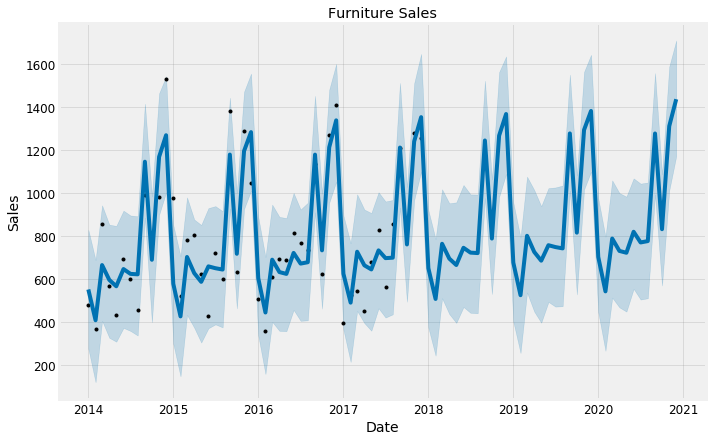

In [48]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

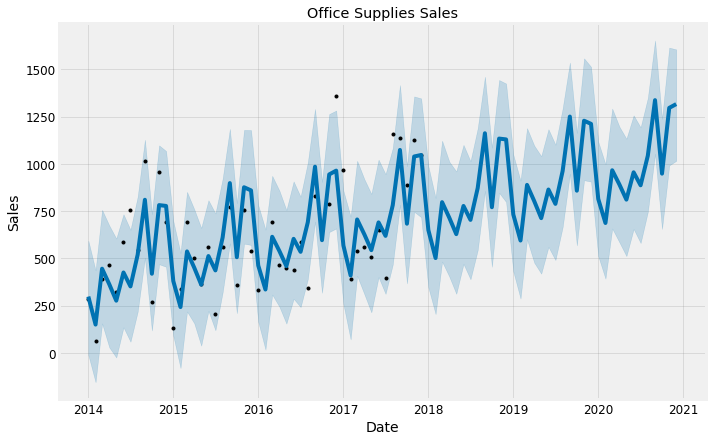

In [49]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

### Compare Forecasts

We already have the forecasts for three years for these two categories into the future. We will now join them together to compare their future forecasts.

In [53]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')

forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_trend_lower,furniture_trend_upper,furniture_yhat_lower,furniture_yhat_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_multiplicative_terms,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_yhat
0,2014-01-01,731.079361,731.079361,731.079361,276.869806,829.451704,-178.836100,-178.836100,-178.836100,0.0,...,-132.483942,-132.483942,-132.483942,0.0,0.0,0.0,-132.483942,-132.483942,-132.483942,297.865749
1,2014-02-01,733.206972,733.206972,733.206972,121.041537,688.538214,-324.048145,-324.048145,-324.048145,0.0,...,-288.226070,-288.226070,-288.226070,0.0,0.0,0.0,-288.226070,-288.226070,-288.226070,149.595672
2,2014-03-01,735.128684,735.128684,735.128684,407.083799,943.409265,-69.406915,-69.406915,-69.406915,0.0,...,0.829065,0.829065,0.829065,0.0,0.0,0.0,0.829065,0.829065,0.829065,445.399757
3,2014-04-01,737.256294,737.256294,737.256294,327.584872,853.485003,-140.477169,-140.477169,-140.477169,0.0,...,-89.156127,-89.156127,-89.156127,0.0,0.0,0.0,-89.156127,-89.156127,-89.156127,362.886617
4,2014-05-01,739.315271,739.315271,739.315271,309.487518,847.622423,-172.355011,-172.355011,-172.355011,0.0,...,-183.195734,-183.195734,-183.195734,0.0,0.0,0.0,-183.195734,-183.195734,-183.195734,276.078026


### Visualizing the trend and the forecast

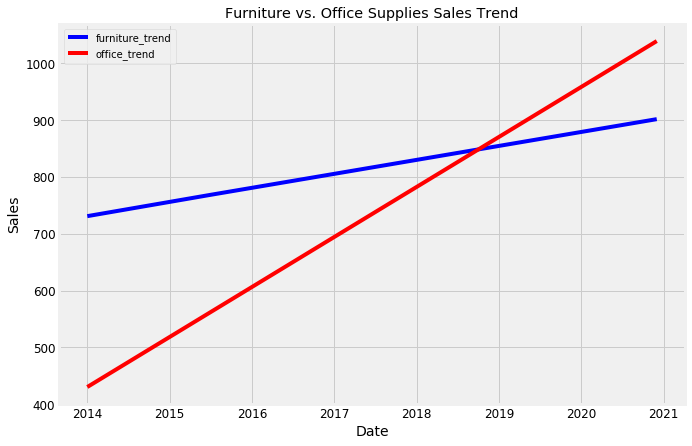

In [62]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

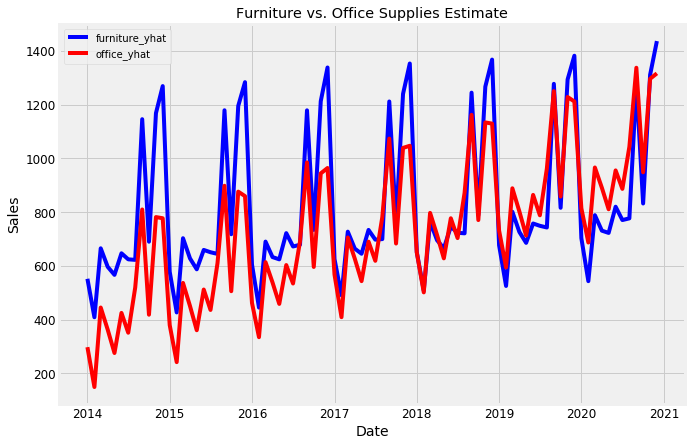

In [63]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

### Trends and Patterns

Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

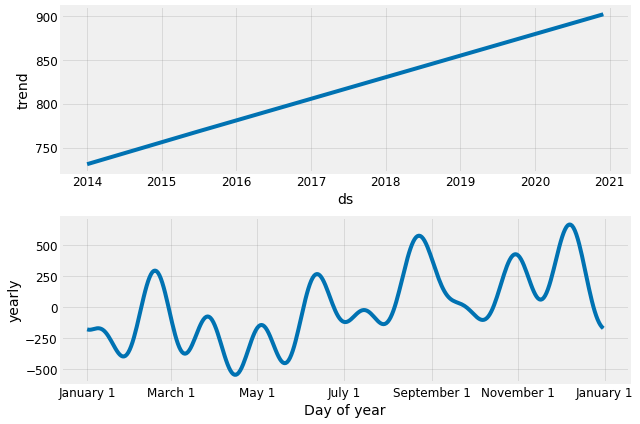

In [68]:
furniture_model.plot_components(furniture_forecast);

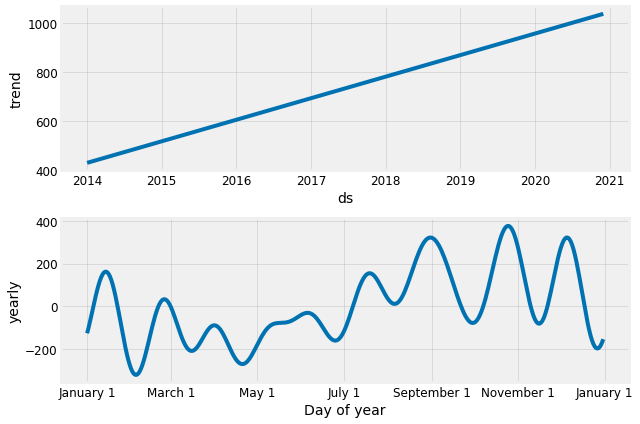

In [70]:
office_model.plot_components(office_forecast);

Good to see that the sales for both furniture and office supplies have been linearly increasing over time although office supplies' growth seems slightly stronger.

The worst month for furniture is April, the worst month for office supplies is February. The best month for furniture is December, and the best month for office supplies is November.

There are many time-series analysis we can explore from now on, such as forecast with uncertainty bounds, change point and anomaly detection, forecast time-series with external data source. We have only scratched the surface here. Stay tuned for future works on time-series analysis.